# Google PlayStore Dataset Analysis

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error # 0.3 error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## 2. Read and print data

In [2]:
df = pd.read_csv('data/googleplaystore.csv')

In [3]:
df.shape

(10841, 13)

In [4]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
print('Column data-types:')
df.dtypes

Column data-types:


App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

## 3. Preprocessing

In [6]:
print(df.isnull().sum())
#drop null values
df.dropna(inplace=True)

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [7]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(8886, 13)

In [9]:
#preprocessing of features to numerical format

#reviews is just a number
df.Reviews = df.Reviews.astype('int64')

In [10]:
#installs e.g. '50,000,000+''
df['Installs'] = df['Installs'].map(lambda x: x.rstrip('+'))
df['Installs'] = df['Installs'].map(lambda x: ''.join(x.split(',')))

In [11]:
#size e.g. '19M'
df['Size'] = df['Size'].map(lambda x: x.rstrip('M'))
df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
df['Size'] = df['Size'].map(lambda x: np.nan if x.startswith('Varies') else x)

In [12]:
#price
df['Price'] = df['Price'].map(lambda x: x.lstrip('$').rstrip())

In [13]:
#content rating
# label encoding
lb_make = LabelEncoder()
# create column for "numeric" Content Rating 
df["Content Rating NUM"] = lb_make.fit_transform(df["Content Rating"])

In [14]:
# create column for "numeric" Category
df["Category NUM"] = lb_make.fit_transform(df["Category"])

In [15]:
# rating
# SimpleImputer fills mean instead of 'NaN'
imputer = SimpleImputer()
df['Rating'] = imputer.fit_transform(df[['Rating']])

In [16]:
# eound rating to 1 decimal place
df['Rating'].round(1)
# important to check
# df["Rating"] = df["Reviews"].apply(lambda x: 1 if x > 3 else 0)

0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10834    4.0
10836    4.5
10837    5.0
10839    4.5
10840    4.5
Name: Rating, Length: 8886, dtype: float64

In [17]:
df['Installs'] = pd.to_numeric(df['Installs'])
df['Price'] = pd.to_numeric(df['Price'])
df.dtypes

App                    object
Category               object
Rating                float64
Reviews                 int64
Size                   object
Installs                int64
Type                   object
Price                 float64
Content Rating         object
Genres                 object
Last Updated           object
Current Ver            object
Android Ver            object
Content Rating NUM      int64
Category NUM            int64
dtype: object

In [18]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Content Rating NUM,Category NUM
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,4,0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0


## 4. Model

In [19]:
features = ['Category NUM', 'Reviews', 'Size', 'Installs', 'Price', 'Content Rating NUM']
#get only preprocessed features

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

X = df[features]
# Label selection
y = df.Rating
y=y.astype('int')

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [21]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

### Logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression
clf_1 = LogisticRegression().fit(X_train, y_train)
 
# Predict on training set
pred_y_1 = clf_1.predict(X_test)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_1 ) )
# [0 1]
 
from sklearn.metrics import accuracy_score
print( accuracy_score(y_test, pred_y_1) )
lr_ac = accuracy_score(y_test, pred_y_1)

[3 4]
0.7223719676549866


### DecisionTree Classifier

In [23]:
dtree_c=DecisionTreeClassifier(criterion='entropy',random_state=0)
dtree_c.fit(X_train,y_train)
dtree_pred=dtree_c.predict(X_test)
dtree_cm=confusion_matrix(y_test,dtree_pred)
dtree_ac=accuracy_score(dtree_pred,y_test)
print(dtree_ac)

0.6462264150943396


### SVM regressor

In [24]:
svc_r=SVC(kernel='rbf')
svc_r.fit(X_train,y_train)
svr_pred=svc_r.predict(X_test)
svr_cm=confusion_matrix(y_test,svr_pred)
svr_ac=accuracy_score(y_test, svr_pred)
print(svr_ac)

0.7230458221024259


### RandomForest

In [25]:
rdf_c=RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
rdf_c.fit(X_train,y_train)
rdf_pred=rdf_c.predict(X_test)
rdf_cm=confusion_matrix(y_test,rdf_pred)
rdf_ac=accuracy_score(rdf_pred,y_test)
print(rdf_ac)

0.7021563342318059


### MLPClassifier

In [26]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [47]:
pipeline = Pipeline([('preprocessing', StandardScaler()), ('classifier', MLPClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(7)],#(20,10)
            'classifier__learning_rate_init': [0.1,#0.001
#                                                0.01, 0.1
                                              ],
            'classifier__max_iter': [20,
#                                      500, 1000
                                    ],
            'classifier__batch_size': [8
#                                        , 16,32
                                      ],
}
kfold=10
grid = GridSearchCV(pipeline, param_grid, cv=kfold, return_train_score=True)

grid.fit(X_train, y_train)
grid.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


{'classifier__batch_size': 8,
 'classifier__hidden_layer_sizes': 7,
 'classifier__learning_rate_init': 0.1,
 'classifier__max_iter': 20,
 'preprocessing': StandardScaler()}

In [48]:
from sklearn import metrics
mlp_ac = metrics.accuracy_score(y_test , grid.predict(X_test))
mlp_ac

0.7223719676549866

### K-Nearest Neighbors Model

In [54]:
# from sklearn import metrics
# from sklearn import preprocessing
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split

In [55]:
# model = KNeighborsRegressor(n_neighbors=15)
# model.fit(X_train, y_train)
# accuracy = model.score(X_test,y_test)
# 'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'
# n_neighbors = np.arange(1, 20, 1)
# scores = []
# for n in n_neighbors:
#     model.set_params(n_neighbors=n)
#     model.fit(X_train, y_train)
#     scores.append(model.score(X_test, y_test))
# plt.figure(figsize=(7, 5))
# plt.title("Effect of Estimators")
# plt.xlabel("Number of Neighbors K")
# plt.ylabel("Score")
# plt.plot(n_neighbors, scores)

### Comparision

Text(0.5, 1.0, 'Model Accracy')

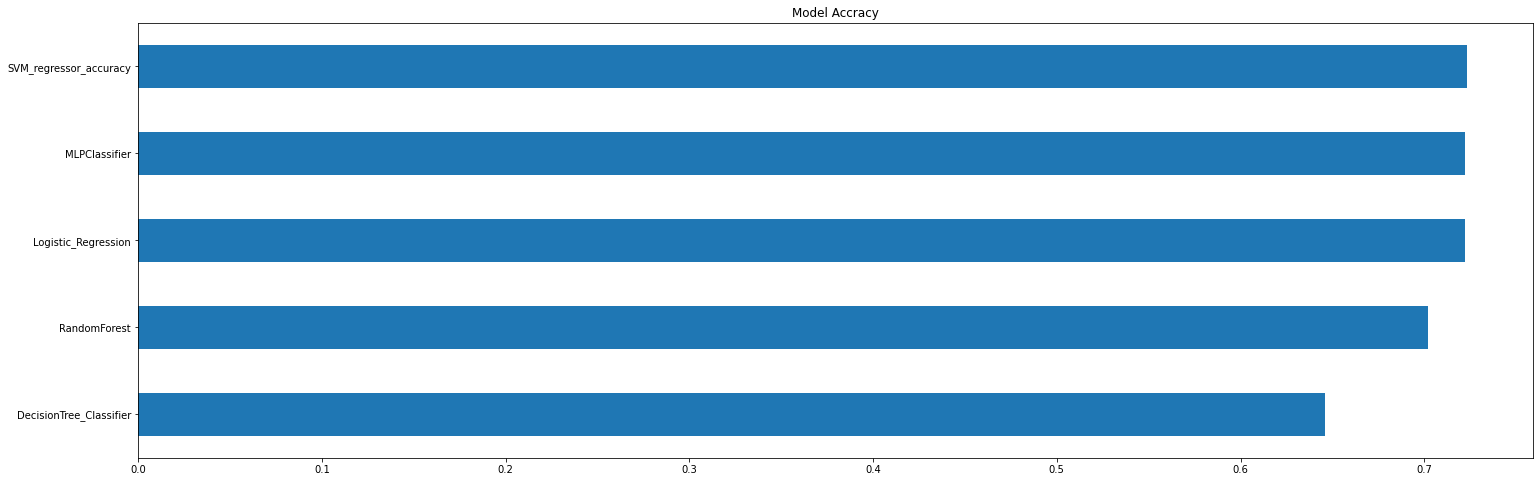

In [56]:
model_accuracy = pd.Series(data=[lr_ac,dtree_ac,svr_ac,rdf_ac,mlp_ac], 
        index=['Logistic_Regression','DecisionTree_Classifier','SVM_regressor_accuracy','RandomForest', 'MLPClassifier'])
fig= plt.figure(figsize=(25,8))
model_accuracy.sort_values().plot.barh()
plt.title('Model Accracy')

Udało się uzyskać kilka modeli o porównywalnej skuteczności.